In [29]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

# 1. 监督学习基本形式：从数学到代码

## 1.1 监督学习问题的抽象

我们有一堆带标签的数据：
$$
{(x_i, y_i)}_{i=1}^n,\quad x_i \in \mathbb{R}^d,; y_i \in \mathcal{Y}
$$

目标：在某个假设空间（模型家族） (\mathcal{H}) 中找到一个函数 (F)，让它在未来的样本上预测尽量准：

$$
F \in \mathcal{H},\quad \text{希望 } F(x) \approx y
$$

我们用**损失函数** ($l(F(x), y)$) 衡量预测的好坏，比如：

* 回归：($l(F(x), y) = (F(x) - y)^2$)
* 分类：($l(F(x), y) = \mathbf{1}[F(x) \neq y]$) 或 交叉熵

理想目标是最小化**真实分布上的期望损失**：

$$
L(F) = \mathbb{E}_{(x,y)\sim D}\big[l(F(x), y)\big]
$$

但真实分布 (D) 不知道，只能用有限训练集近似——得到**经验风险**：

$$
\hat L(F) = \frac{1}{n}\sum_{i=1}^n l(F(x_i), y_i)
$$

> 训练的本质就是：
> **在模型参数上做优化，让 &(\hat L(F))$ 尽可能小。**

$$
\hat L(F) = \frac{1}{n}\sum_{i=1}^n l(F(x_i), y_i)
$$

> 训练的本质就是：
> **在模型参数上做优化，让 $$\hat L(F)$$ 尽可能小。**

## 1.2 我们先写一个通用“训练 Loop”骨架（伪代码）

后面所有模型（线性、MLP）都会是这个模式的实例。


In [30]:
def train_generic(model, loss_fn, optimizer, train_loader, epochs=20, device="cpu"):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_n = 0
        for x, y in train_loader:
            x = x.to(device).float()
            y = y.to(device).float()

            # 1. 前向
            y_pred = model(x)

            # 2. 损失
            loss = loss_fn(y_pred, y)

            # 3. 反向传播 & 更新
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            total_n += x.size(0)

        print(f"Epoch {epoch+1}: loss = {total_loss / total_n:.4f}")


# 2. 数据预处理理论与代码

* 数值尺度差异大 → 不利于训练（梯度震荡、收敛慢）
* 特征有不同量纲 → 需要归一化
* 类别特征 → 要转成 one-hot

## 2.1 Z-score 标准化

理论上：

$$
x^{\text{norm}} = \frac{x - \mu}{\sigma}
$$

其中 ($\mu$) 是均值，($\sigma$) 是标准差。每一维都减均值、除标准差。

In [31]:
def z_score_normalize(x: torch.Tensor, dim=0, eps=1e-8):
    """
    x: 任意形状的 Tensor，比如 (N, D)
    dim: 沿着哪个维度计算均值/标准差，通常是 0 (batch 维)
    """
    mean = x.mean(dim=dim, keepdim=True)
    std = x.std(dim=dim, keepdim=True)
    return (x - mean) / (std + eps)


X = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0],
                  [7.0, 8.0, 9.0]])
X_norm = z_score_normalize(X, dim=0)
print(X_norm)
X_norm_ = z_score_normalize(X, dim=1)
print(X_norm_)

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])
tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]])



## 2.2 Min-Max 归一化

理论上：

$$
x^{\text{norm}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

常用于把数据拉到 ([0,1]) 范围。

In [32]:
def min_max_normalize(x: torch.Tensor, dim=0, eps=1e-8):
    x_min, _ = x.min(dim=dim, keepdim=True)
    x_max, _ = x.max(dim=dim, keepdim=True)
    return (x - x_min) / (x_max - x_min + eps)

X = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0],
                  [7.0, 8.0, 9.0]])
X_norm = min_max_normalize(X, dim=0)
print(X_norm)
X_norm_ = min_max_normalize(X, dim=1)
print(X_norm_)  

tensor([[0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000],
        [1.0000, 1.0000, 1.0000]])
tensor([[0.0000, 0.5000, 1.0000],
        [0.0000, 0.5000, 1.0000],
        [0.0000, 0.5000, 1.0000]])


## 2.3 类别特征的 One-Hot 编码

例如：

* small → 0 → [1,0,0]
* medium → 1 → [0,1,0]
* large → 2 → [0,0,1]

In [33]:
def one_hot_encode(labels: torch.Tensor, num_classes: int):
    """
    labels: (N,) int64
    返回: (N, num_classes) float
    """
    return F.one_hot(labels, num_classes=num_classes).float()

# 示例
labels = torch.tensor([0, 1, 2, 1, 0])
num_classes = 3
one_hot_labels = one_hot_encode(labels, num_classes)
print(one_hot_labels)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]])


## 2.4 一个简单的可视化：归一化前后对比

我们生成一堆二维点，两个维度尺度差别很大，看归一化效果。


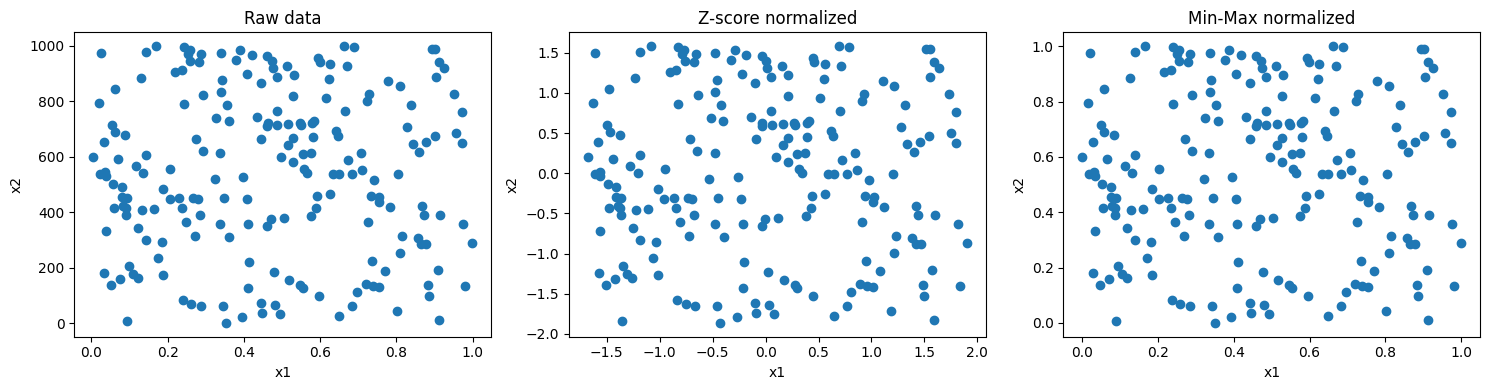

In [34]:
#@title 生成 toy 数据并可视化归一化效果

N = 200
# 第 1 维是 0~1 的随机数，第 2 维是 0~1000 的随机数
x1 = torch.rand(N, 1)
x2 = torch.rand(N, 1) * 1000
X_raw = torch.cat([x1, x2], dim=1)

X_z = z_score_normalize(X_raw, dim=0)
X_mm = min_max_normalize(X_raw, dim=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(X_raw[:, 0], X_raw[:, 1])
axes[0].set_title("Raw data")

axes[1].scatter(X_z[:, 0], X_z[:, 1])
axes[1].set_title("Z-score normalized")

axes[2].scatter(X_mm[:, 0], X_mm[:, 1])
axes[2].set_title("Min-Max normalized")

for ax in axes:
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

你会看到：

* 原始数据在 y 轴上拉得很长；
* 归一化后的点云更「球形」，对很多模型更友好。

# 3. 线性回归：理论 + 从零实现 + PyTorch 实现

## 3.1 理论回顾

**模型：**

$$
f_w(x) = w^\top x + b,\quad w \in \mathbb{R}^d,; b \in \mathbb{R}
$$

**目标：**（使用 L2 损失）

$$
\hat L(w,b) = \frac{1}{n}\sum_{i=1}^n (f_w(x_i) - y_i)^2
$$

对 (w,b) 求梯度，用梯度下降更新：

$$
w \leftarrow w - \eta \frac{\partial \hat L}{\partial w},\quad
b \leftarrow b - \eta \frac{\partial \hat L}{\partial b}
$$

---

## 3.2 先造一个一维线性数据集

比如真实关系：

$$
y = 3x + 1 + \text{噪声}
$$

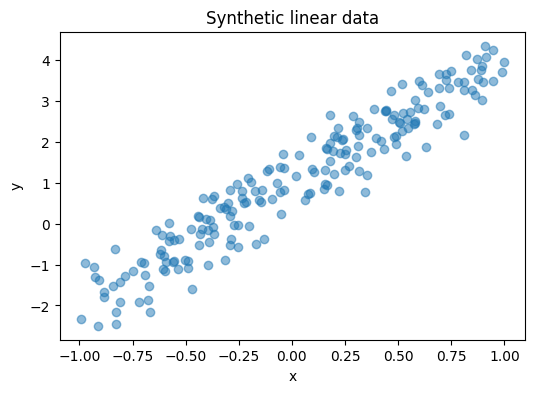

In [35]:
def generate_linear_data(n_samples=200, w_true=3.0, b_true=1.0, noise_std=0.5):
    x = torch.rand(n_samples, 1) * 2 - 1  # [-1, 1]
    noise = torch.randn(n_samples, 1) * noise_std
    y = w_true * x + b_true + noise
    return x, y

X_lin, y_lin = generate_linear_data()

plt.scatter(X_lin.numpy(), y_lin.numpy(), alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Synthetic linear data")
plt.show()

## 3.3 线性回归：纯 PyTorch Tensor + 手写训练循环（不使用 `nn.Module`）

这部分更贴合“经验风险 + 梯度下降”的数学形式。


In [36]:
def train_linear_regression_scratch(X, y, lr=0.5, epochs=200):
    """
    X: (N, D)
    y: (N, 1)
    """
    N, D = X.shape
    X = X.float()
    y = y.float()

    # 参数初始化
    w = torch.zeros(D, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    for epoch in range(epochs):
        # 前向
        y_pred = X @ w + b  # (N,1)

        # L2 损失：均方误差
        loss = ((y_pred - y) ** 2).mean()

        # 反向
        loss.backward()

        with torch.no_grad():
            w -= lr * w.grad
            b -= lr * b.grad

        # 清梯度
        w.grad.zero_()
        b.grad.zero_()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: loss = {loss.item():.4f}, w = {w.item():.4f}, b = {b.item():.4f}")

    return w.detach(), b.detach()

w_hat, b_hat = train_linear_regression_scratch(X_lin, y_lin)

print("Learned w:", w_hat.item())
print("Learned b:", b_hat.item())

Epoch 20: loss = 0.2502, w = 2.9895, b = 1.0124
Epoch 40: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 60: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 80: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 100: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 120: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 140: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 160: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 180: loss = 0.2502, w = 2.9927, b = 1.0122
Epoch 200: loss = 0.2502, w = 2.9927, b = 1.0122
Learned w: 2.9926931858062744
Learned b: 1.0122249126434326


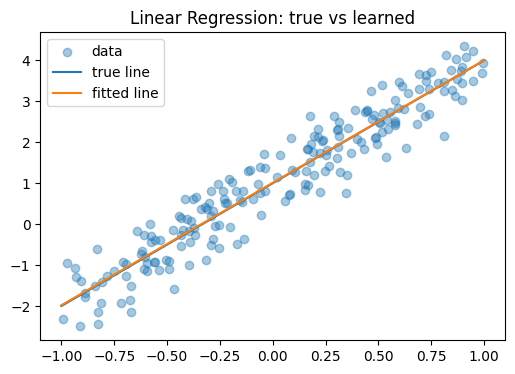

In [37]:
#@title 可视化拟合直线
with torch.no_grad():
    x_plot = torch.linspace(-1, 1, 100).unsqueeze(1)
    y_true = 3.0 * x_plot + 1.0
    y_pred = w_hat * x_plot + b_hat

plt.scatter(X_lin.numpy(), y_lin.numpy(), alpha=0.4, label="data")
plt.plot(x_plot.numpy(), y_true.numpy(), label="true line")
plt.plot(x_plot.numpy(), y_pred.numpy(), label="fitted line")
plt.legend()
plt.title("Linear Regression: true vs learned")
plt.show()

## 3.4 线性回归：用 `nn.Module` 和 DataLoader（更贴近实际工程）

我们把上面的东西封装成一个 `Dataset` + `DataLoader` + `nn.Module`。

In [38]:
class LinearRegressionDataset(Dataset):
    def __init__(self, n_samples=200):
        self.X, self.y = generate_linear_data(n_samples=n_samples)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = LinearRegressionDataset(n_samples=200)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [39]:
class LinearRegressionModel(nn.Module):
    def __init__(self, in_features=1, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
    
model_lr = LinearRegressionModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_lr.parameters(), lr=0.5)

In [40]:
def train_linear_model(model, train_loader, loss_fn, optimizer, epochs=30, device="cpu"):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_n = 0
        for x, y in train_loader:
            x = x.to(device).float()
            y = y.to(device).float()  # (N,1)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            total_n += x.size(0)

        print(f"Epoch {epoch+1}: loss = {total_loss / total_n:.4f}")

train_linear_model(model_lr, train_loader, loss_fn, optimizer, epochs=30)

print("Learned weight & bias:", list(model_lr.parameters()))

Epoch 1: loss = 2.0560
Epoch 2: loss = 0.3101
Epoch 3: loss = 0.2750
Epoch 4: loss = 0.2708
Epoch 5: loss = 0.2584
Epoch 6: loss = 0.2832
Epoch 7: loss = 0.2808
Epoch 8: loss = 0.2683
Epoch 9: loss = 0.2615
Epoch 10: loss = 0.2620
Epoch 11: loss = 0.2735
Epoch 12: loss = 0.2832
Epoch 13: loss = 0.2780
Epoch 14: loss = 0.2675
Epoch 15: loss = 0.2623
Epoch 16: loss = 0.2596
Epoch 17: loss = 0.2658
Epoch 18: loss = 0.2764
Epoch 19: loss = 0.2617
Epoch 20: loss = 0.2617
Epoch 21: loss = 0.2636
Epoch 22: loss = 0.2861
Epoch 23: loss = 0.2679
Epoch 24: loss = 0.2656
Epoch 25: loss = 0.2772
Epoch 26: loss = 0.2612
Epoch 27: loss = 0.2764
Epoch 28: loss = 0.2647
Epoch 29: loss = 0.2670
Epoch 30: loss = 0.2761
Learned weight & bias: [Parameter containing:
tensor([[3.0482]], requires_grad=True), Parameter containing:
tensor([0.9057], requires_grad=True)]


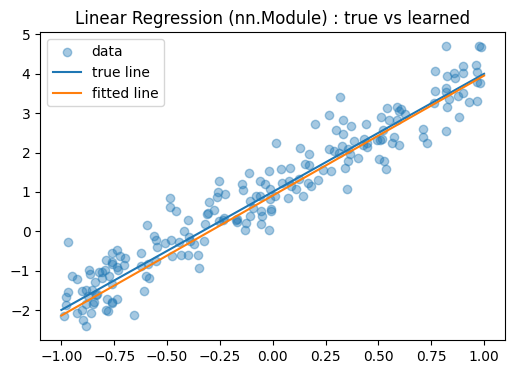

In [41]:
with torch.no_grad():
    x_plot = torch.linspace(-1, 1, 100).unsqueeze(1)
    y_true = 3.0 * x_plot + 1.0
    y_pred = model_lr(x_plot)

plt.scatter(train_dataset.X.numpy(), train_dataset.y.numpy(), alpha=0.4, label="data")
plt.plot(x_plot.numpy(), y_true.numpy(), label="true line")
plt.plot(x_plot.numpy(), y_pred.numpy(), label="fitted line")
plt.legend()
plt.title("Linear Regression (nn.Module) : true vs learned")
plt.show()

# 4. MLP 拟合非线性函数：感受“通用逼近定理”

PPT 里讲了“单隐层神经网络可以逼近任意连续函数”的直觉（用很多 sigmoid 组合成模块）。

这里我们用一个非常经典的例子：**拟合 (y = \sin(x))**。

## 4.1 生成 sin 数据

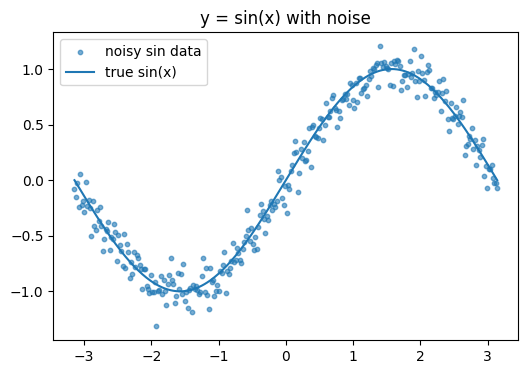

In [42]:

def generate_sin_data(n_samples=300, x_range=(-math.pi, math.pi), noise_std=0.1):
    xs = torch.linspace(x_range[0], x_range[1], n_samples).unsqueeze(1)
    ys = torch.sin(xs) + noise_std * torch.randn_like(xs)
    return xs, ys

X_sin, y_sin = generate_sin_data()

plt.scatter(X_sin.numpy(), y_sin.numpy(), s=10, alpha=0.6, label="noisy sin data")
plt.plot(X_sin.numpy(), torch.sin(X_sin).numpy(), label="true sin(x)")
plt.legend()
plt.title("y = sin(x) with noise")
plt.show()

## 4.2 定义一个简单的 MLP

$$
\text{MLP}(x) = W_2 ,\sigma(W_1 x + b_1) + b_2
$$

用 ReLU / Tanh 都可以。这里用 Tanh 更合适一些（因为 sin 是平滑的）。

In [43]:
class SimpleMLP(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=64, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

In [44]:
class SinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

sin_dataset = SinDataset(X_sin, y_sin)
sin_loader = DataLoader(sin_dataset, batch_size=64, shuffle=True)

## 4.3 训练 MLP 拟合 sin

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

mlp = SimpleMLP(in_dim=1, hidden_dim=64, out_dim=1).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

epochs = 200
for epoch in range(epochs):
    mlp.train()
    total_loss = 0.0
    total_n = 0

    for x, y in sin_loader:
        x = x.to(device).float()
        y = y.to(device).float()

        y_pred = mlp(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_n += x.size(0)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: loss = {total_loss / total_n:.4f}")

Using device: cpu
Epoch 20: loss = 0.0193
Epoch 40: loss = 0.0162
Epoch 60: loss = 0.0137
Epoch 80: loss = 0.0131
Epoch 100: loss = 0.0152
Epoch 120: loss = 0.0144
Epoch 140: loss = 0.0128
Epoch 160: loss = 0.0130
Epoch 180: loss = 0.0144
Epoch 200: loss = 0.0135


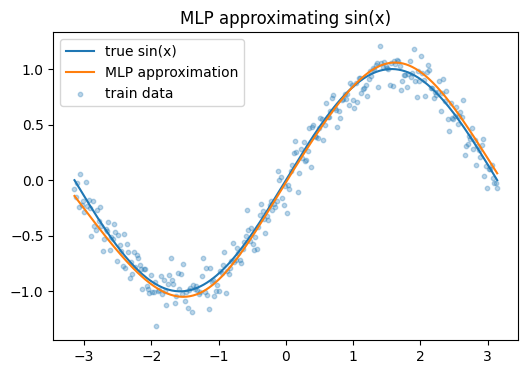

In [46]:
mlp.eval()
with torch.no_grad():
    x_test = torch.linspace(-math.pi, math.pi, 400).unsqueeze(1).to(device)
    y_true = torch.sin(x_test)
    y_pred = mlp(x_test)

x_test_np = x_test.cpu().numpy()
y_true_np = y_true.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

plt.plot(x_test_np, y_true_np, label="true sin(x)")
plt.plot(x_test_np, y_pred_np, label="MLP approximation")
plt.scatter(X_sin.numpy(), y_sin.numpy(), s=10, alpha=0.3, label="train data")
plt.legend()
plt.title("MLP approximating sin(x)")
plt.show()


> 你会看到：
>
> * 训练充分后，MLP 的输出曲线几乎贴着 sin 曲线走
> * 这就是“单隐层网络可以逼近任意连续函数”的一个直观小例子

---

# 5. 小结 & 你可以进一步做的事情

在这个 Notebook 里，我们从第一章的理论出发，落地了几个关键代码：

1. **监督学习形式 → 训练 loop 模板**
2. **数据预处理**

   * Z-score 归一化
   * Min-Max 归一化
   * one-hot 编码
   * 简单可视化展示归一化效果
3. **线性回归**

   * 纯 Tensor + 手写梯度下降版本（更贴数学）
   * `nn.Module` + DataLoader 版本（更贴工程）
4. **简单 MLP 拟合 sin(x)**

   * 感受“通用逼近定理”的直观意义：单隐层网络逼近复杂函数